In [23]:
import numpy as np
import pyfits
import math
from math import log10
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from matplotlib import rc
import pickle
import os
import astropy as ap
from astropy.cosmology import WMAP7
from scipy import interpolate
import corner
import matplotlib.patheffects as patheffects
from matplotlib import rcParams

# rcParams["font.size"] = 16
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
#rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = 'Ubuntu'
# rcParams['font.monospace'] = 'Ubuntu Mono'
rcParams['font.size'] = 15
rcParams['axes.labelsize'] = 15
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['legend.fontsize'] = 13
rcParams['figure.titlesize'] = 1



In [24]:
os.chdir('/Users/nitya/Work/Data/Project1/edge_effects')
print(os.getcwd())

a = pyfits.open("lss_combmask.dr72.fits")
a = a[1].data
print(a.columns)

os.chdir('/Users/nitya/Work/Data/Project1/measurements')
print(os.getcwd())

ile = open(r'interpolated_data_radec.pkl','rb')
d = pickle.load(ile, encoding ='latin1')
ile.close()
print(d.dtype.names)

/Users/nitya/Work/Data/Project1/edge_effects
ColDefs(
    name = 'XCAPS'; format = '42D'; dim = '( 3, 14)'
    name = 'CMCAPS'; format = '14D'
    name = 'NCAPS'; format = 'J'
    name = 'WEIGHT'; format = 'D'
    name = 'STR'; format = 'D'
    name = 'USE_CAPS'; format = 'J'; bscale = 1; bzero = 2147483648
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'SECTOR'; format = 'J'
    name = 'MMAX'; format = 'E'
    name = 'DIFFRUN'; format = 'J'
    name = 'ITILING_GEOMETRY'; format = 'J'
    name = 'ITARGET_GEOMETRY'; format = 'J'
    name = 'ILSS'; format = 'J'
    name = 'FGOTMAIN'; format = 'E'
)
/Users/nitya/Work/Data/Project1/measurements
('nsaid', 'z', 'ra', 'dec', 'opt', 'inf', 'mass', 'magsfr', 'magphys', 'uv', 'uvssfr', 'env')


In [25]:
#let's divide the MASK up into (a)region without the southern stripes (b) stripes on either side;
ind1 = np.where(a['ra']>=100)[0]
a1 = a[ind1]
ind2 = np.where(a1['ra']<=270)[0]
a1 = a1[ind2]
ind3 = np.where(a['ra']<100)[0]
a2 = a[ind3]
ind4 = np.where(a['ra']>270)[0]
a3 = a[ind4]

area2 = np.sum(a2['STR'])
print(area2)
area3 = np.sum(a3['STR'])
print(area3)

0.118444022364
0.104399854845


[[ 0.95543706  0.62981233]
 [ 0.35603505  0.21745488]]
[ 109.  215.  267.]
[ -4.  33.  71.]
579437


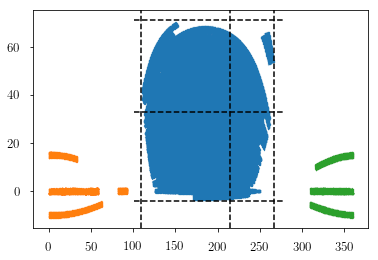

[[ 8.06657049  5.3173838 ]
 [ 3.00593517  1.83592952]]
0.881427806662


In [26]:
b1 = [ 109,215,267]
b2 = [ -4,33,71]

g = binned_statistic_2d(a1['ra'],a1['dec'],a1['str'], statistic = 'sum', bins = (b1,b2))
print(g[0])
print(g[1])
print(g[2])
print(len(g[3]))
plt.scatter(a1['RA'],a1['DEC'], s = 0.01)
for i in range(len(g[2])):
    plt.axhline(y = g[2][i],xmin = 0.3,xmax = 0.75, linestyle = '--', color = 'k')
for i in range(len(g[1])):
    plt.axvline(x = g[1][i], linestyle = '--', color = 'k')
plt.scatter(a2['RA'],a2['DEC'], s = 0.01)
plt.scatter(a3['RA'],a3['DEC'], s = 0.01)
plt.show()
#here's the "factor" matrix for how to split up them volumes:
res = g[0]/area2
res2 = area3/area2
print(res)
print(res2)

In [27]:
#so 8+5+3+2+2 = 20 jackknife regions with comoving volumes of ~ well we'll get to it;
# Dividing up my sample with the same binning first;
print(len(d))
ind1, = np.where(d['ra']>=110)
d1 = d[ind1]
ind2, = np.where(d1['ra']<=267)
d1 = d1[ind2]
print(len(d1))
ind3, = np.where(d['ra']<110)
d2 = d[ind3]
ind4, = np.where(d['ra']>267)
d3 = d[ind4]
print(len(d2))
print(len(d3))

h = binned_statistic_2d(d1['ra'],d1['dec'],d1['nsaid'], statistic = 'count', bins = (b1,b2))
print(np.unique(h[3]))
print(np.unique(g[3]))
steridian = np.ravel(g[0])
ratio = np.ravel(res)


61046
55696
3599
1751
[ 5  6  9 10]
[ 5  6  9 10]


In [28]:
print(len(h[3]))
bins = np.unique(h[3])

ind = [np.where(h[3]==bins[i]) for i in range(len(bins))]
ids_z = [np.column_stack((d1['nsaid'][np.where(h[3]==bins[i])],
                          d1['z'][np.where(h[3]==bins[i])])) for i in range(len(bins))]

print(np.shape(ids_z))
#print(array[0])
array2 = np.column_stack((bins,steridian, ratio,ids_z))
print(np.shape(array2[:,3][0]))


55696
(4,)
(23165, 2)


In [29]:
zmax = np.max(d['z'])
z_array = np.linspace(0,zmax,10000)
comvol_array = WMAP7.comoving_volume(z_array).value
#Remember all the volumes are in Mpc^^3
maxvol = WMAP7.comoving_volume(zmax).value
print(zmax,maxvol)

0.0550014674664 52005388.21882485


In [30]:
#now to break up them volumes...

def get_index(n):
    v = np.arange(n)
    vol = v*maxvol/n
    ind = []
    for j in range(len(v)):
        res = [abs(comvol_array[i]-vol[j]) for i in range(len(comvol_array))]
        index, = np.where(res==np.min(res))
        ind.append(np.asscalar(index))
    return(ind)

In [31]:
array3 = []

for i in range(4):
    #no of partitions needed
    p = np.rint(ratio[i])
    print(p)
    binz = z_array[get_index(p)]
    id_array = array2[:,3][i][:,0]
    redshifts = array2[:,3][i][:,1]
    w = binned_statistic(redshifts,id_array,statistic = 'count',bins = binz)
    bin_id = np.unique(w[2])
    
    for j in range(len(bin_id)):
        thing = id_array[np.where(w[2]==bin_id[j])[0]]
        array3.append(thing)
    

array3.append(d2['nsaid'])
array3.append(d3['nsaid'])

print(len(array3))
#print(array3)


8.0
5.0
3.0
2.0
20


In [32]:

afile = open(r'jk_list.pkl', 'wb')
pickle.dump(array3, afile)
afile.close()

In [33]:

# #Comdis stuff:
# d2 = WMAP7.comoving_distance(0.055).value
# def comvol(n):
#     d1 = WMAP7.comoving_distance(0.055/n).value
#     vol = (d2**3-d1**3)
#     return vol


#let's figure out which area belongs to which bin....
# l1 = [ 109,165,267]
# l2 = [ -4,9,71]

# g = binned_statistic_2d(a1['ra'],a1['dec'],a1['str'], statistic = 'sum', bins = (l1,l2))
# print(np.flipud(np.transpose(g[0])))
# print(g[1])
# print(g[2])
# print(len(g[3]))
# plt.scatter(a1['RA'],a1['DEC'], s = 0.01)
# for i in range(len(g[2])):
#     plt.axhline(y = g[2][i],xmin = 0.3,xmax = 0.75, linestyle = '--', color = 'k')
# for i in range(len(g[1])):
#     plt.axvline(x = g[1][i], linestyle = '--', color = 'k')
# plt.scatter(a2['RA'],a2['DEC'], s = 0.01)
# plt.scatter(a3['RA'],a3['DEC'], s = 0.01)
# plt.show()

# print(g[0])
# print(np.ravel(g[0]))
# print(np.unique(g[3]))
# indi, = np.where(g[3]==5)
# print(len(a1['ra'][indi]))
# print(a1['ra'][indi])
# print(a1['dec'][indi])
# indi, = np.where(g[3]==6)
# print(len(a1['ra'][indi]))
# print(a1['ra'][indi])
# print(a1['dec'][indi])
# indi, = np.where(g[3]==9)
# print(len(a1['ra'][indi]))
# print(a1['ra'][indi])
# print(a1['dec'][indi])
# indi, = np.where(g[3]==10)
# print(len(a1['ra'][indi]))
# print(a1['ra'][indi])
# print(a1['dec'][indi])